In [69]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from xgboost import XGBClassifier
from scipy.sparse import hstack
from matplotlib import pyplot as plt
import re
import string

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
## GLOBAL VARIABLES
SEED = 42
FOLDS = 5 # number of folds that we will create in the next steps
np.random.seed(SEED)

## Data Cleaning

### Removing URLs

In [9]:
train[train.text.str.contains("https.")].shape[0]

407

In [10]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

train['text'] = train['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

In [11]:
train[train.text.str.contains("https.")].shape[0]

0

### Removing punctuation marks

In [12]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

### Removing multiple whitespaces

In [13]:
train['text']=train['text'].str.replace('   ', ' ')
train['text']=train['text'].str.replace('     ', ' ')
train['text']=train['text'].str.replace('\xa0 \xa0 \xa0', ' ')
train['text']=train['text'].str.replace('  ', ' ')
train['text']=train['text'].str.replace('—', ' ')
train['text']=train['text'].str.replace('–', ' ')

test['text']=test['text'].str.replace('   ', ' ')
test['text']=test['text'].str.replace('     ', ' ')
test['text']=test['text'].str.replace('\xa0 \xa0 \xa0', ' ')
test['text']=test['text'].str.replace('  ', ' ')
test['text']=test['text'].str.replace('—', ' ')
test['text']=test['text'].str.replace('–', ' ')

In [14]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [17]:
train[train.keyword.isna()]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,ariaahrary TheTawniest The out of control wild...,1
7610,10871,NaN,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating after an ebike collided w...,1


### Treating missing values

In [18]:
train.fillna("5555", inplace=True)
test.fillna("5555", inplace=True)

In [19]:
train.head()

,id,keyword,location,text,target
0,1,5555,5555,Our Deeds are the Reason of this earthquake Ma...,1
1,4,5555,5555,Forest fire near La Ronge Sask Canada,1
2,5,5555,5555,All residents asked to shelter in place are be...,1
3,6,5555,5555,13000 people receive wildfires evacuation orde...,1
4,7,5555,5555,Just got sent this photo from Ruby Alaska as s...,1


### Stratified k fold split

In [20]:
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

## Model Evaluation

In [21]:
def evaluate_model(y_true, y_pred):    
    # calculate f1 score
    f1 = f1_score(y_true, y_pred)    
    print(f"Validation F1: {f1}")
    print("")
    return f1

### Model scores

In [22]:
def get_model_scores(X, y, pipeline, cv):
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return scores

def print_score_summary(scores):
    for fold, score in enumerate(scores):
        print(f"Fold {fold}:")
        print(f"F1 validation score: {score}")
        print("")
    
    print(f"Average F1 validation: {np.mean(scores)}")

### Plot learning curves

In [23]:
def plot_learning_curve(estimator, X, y, cv, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator,
                                                             X,
                                                             y,
                                                             scoring="f1",
                                                             cv=cv)

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(valid_scores, axis=1)

    train_scores_std = np.std(train_scores, axis=1)
    val_scores_std = np.std(valid_scores, axis=1)

    fig, ax = plt.subplots()
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, val_scores_mean, "o-", color="g", label="Cross-validation score")
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.set_ylim(0.0, 1.01)
    ax.legend(loc="best")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("F1-score")
    ax.set_title(f"{title}")
    plt.show()

## Different models

- Dummy baseline

### Dummy baseline

Steps of the baseline model [('encoder', OneHotEncoder(handle_unknown='ignore')), ('model', LogisticRegression(random_state=42, solver='liblinear'))]


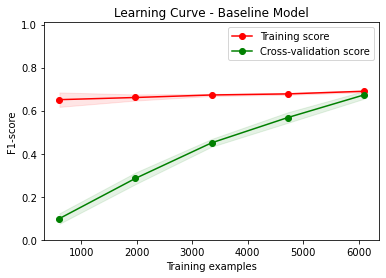

Fold 0:
F1 validation score: 0.6931818181818182

Fold 1:
F1 validation score: 0.6598101265822784

Fold 2:
F1 validation score: 0.6445344129554657

Fold 3:
F1 validation score: 0.6853932584269663

Fold 4:
F1 validation score: 0.680577849117175

Average F1 validation: 0.6726994930527408


In [57]:
# create a list to append the steps of the preprossesing pipeline
steps_baseline = list()
steps_baseline.append(('encoder', OneHotEncoder(handle_unknown='ignore')))
steps_baseline.append(('model', LogisticRegression(solver='liblinear', random_state = SEED)))
print("Steps of the baseline model" ,steps_baseline)
# create the pipeline
pipeline_baseline = Pipeline(steps=steps_baseline)

# get model cross-validated scores.
# using the cross-validation strategy defined
# at the beggining of the notebook
scores = get_model_scores(X=train[['keyword']],
                          y=train['target'],
                          pipeline=pipeline_baseline,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_baseline,
                    X=train[['keyword']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

### Logistic regression with TF-IDF vectorization

In [58]:
steps_tfidf = list()
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
steps_tfidf.append(('tf-idf',vectorizer))
steps_tfidf.append(('model', LogisticRegression(solver='liblinear',random_state = SEED)))
pipeline_tfidf = Pipeline(steps_tfidf)

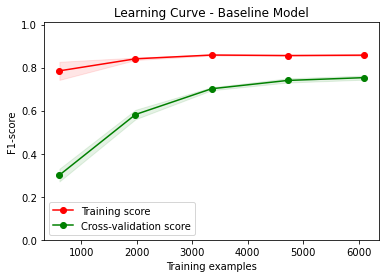

Fold 0:
F1 validation score: 0.7572977481234362

Fold 1:
F1 validation score: 0.7502102607232968

Fold 2:
F1 validation score: 0.7425249169435216

Fold 3:
F1 validation score: 0.746419545071609

Fold 4:
F1 validation score: 0.7694886839899414

Average F1 validation: 0.753188230970361


In [59]:
scores = get_model_scores(X=train.text,
                          y=train['target'],
                          pipeline=pipeline_tfidf,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_tfidf,
                    X=train.text,
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

### Logistic Regression with Count Vectorizer

In [60]:
steps_countvector = list()
count_vectorizer = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
steps_countvector.append(('Count-Vectorizer',count_vectorizer))
steps_countvector.append(('model', LogisticRegression(solver='liblinear', random_state = SEED)))
pipeline_countvector = Pipeline(steps_countvector)

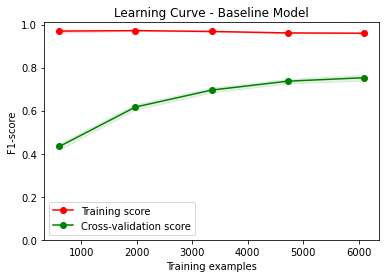

Fold 0:
F1 validation score: 0.7706122448979591

Fold 1:
F1 validation score: 0.7514450867052023

Fold 2:
F1 validation score: 0.7421686746987952

Fold 3:
F1 validation score: 0.7350287120590647

Fold 4:
F1 validation score: 0.7651888341543515

Average F1 validation: 0.7528887105030746


In [61]:
scores = get_model_scores(X=train.text,
                          y=train['target'],
                          pipeline=pipeline_countvector,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_countvector,
                    X=train.text,
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

Looking at the training score, we get a sense that the model is overfitting and hence doing an L2 regularization would help our case

In [62]:
steps_countvector = list()
count_vectorizer = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
steps_countvector.append(('Count-Vectorizer',count_vectorizer))
steps_countvector.append(('model', LogisticRegression(solver='saga',
                                                     C=0.3,
                                                     fit_intercept = False,
                                                     max_iter = 900,
                                                     penalty = 'l2',
                                                     random_state = SEED)))
pipeline_countvector = Pipeline(steps_countvector)

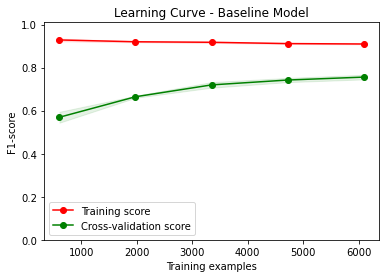

Fold 0:
F1 validation score: 0.7694753577106518

Fold 1:
F1 validation score: 0.7577442414614773

Fold 2:
F1 validation score: 0.7384131971720347

Fold 3:
F1 validation score: 0.7501970055161544

Fold 4:
F1 validation score: 0.7628865979381443

Average F1 validation: 0.7557432799596926


In [63]:
scores = get_model_scores(X=train.text,
                          y=train['target'],
                          pipeline=pipeline_countvector,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_countvector,
                    X=train.text,
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

### Lemmatization and logistic regression with Count Vectorization

In [64]:
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`']
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

In [65]:
steps_lemm = list()
count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
steps_lemm.append(('Count-Vectorizer',count_vectorizer))
steps_lemm.append(('model', LogisticRegression(solver='saga',
                                                     C=0.3,
                                                     fit_intercept = False,
                                                     max_iter = 900,
                                                     penalty = 'l2',
                                              random_state = SEED)))
pipeline_lemm = Pipeline(steps_lemm)

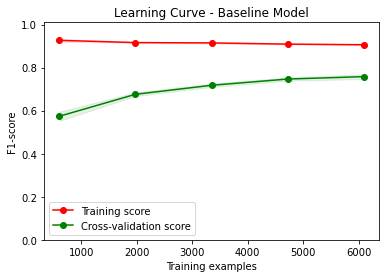

Fold 0:
F1 validation score: 0.7758346581875993

Fold 1:
F1 validation score: 0.7564102564102564

Fold 2:
F1 validation score: 0.7409733124018839

Fold 3:
F1 validation score: 0.7554858934169278

Fold 4:
F1 validation score: 0.7605409705648369

Average F1 validation: 0.7578490181963009


In [66]:
scores = get_model_scores(X=train.text,
                          y=train['target'],
                          pipeline=pipeline_lemm,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_lemm,
                    X=train.text,
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

### Adding the keywords column as well in feature space

In [67]:
steps_text_keyword = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])

#count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
steps_text_keyword.append(('features',col_transformations))
steps_text_keyword.append(('model', LogisticRegression(solver='saga',
                                                     C=0.3,
                                                     fit_intercept = False,
                                                     max_iter = 900,
                                                     penalty = 'l2',
                                                      random_state = SEED)))
pipeline_text_keyword = Pipeline(steps=steps_text_keyword)

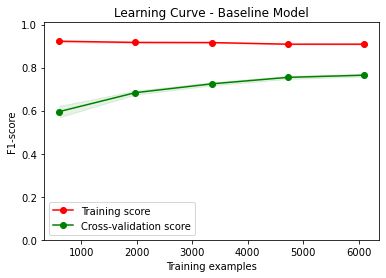

Fold 0:
F1 validation score: 0.7747603833865815

Fold 1:
F1 validation score: 0.7639000805801773

Fold 2:
F1 validation score: 0.7567567567567567

Fold 3:
F1 validation score: 0.7594339622641509

Fold 4:
F1 validation score: 0.7682437850842021

Average F1 validation: 0.7646189936143737


In [68]:
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_text_keyword,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_text_keyword,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

### Using Decision Trees with Lemmatization + Count vectorization

In [85]:
steps_dt = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])

#count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
steps_dt.append(('features',col_transformations))
steps_dt.append(('model', DecisionTreeClassifier(criterion='gini', random_state=SEED)))
pipeline_dt = Pipeline(steps=steps_dt)

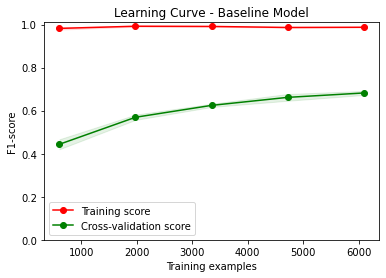

Fold 0:
F1 validation score: 0.6984884645982498

Fold 1:
F1 validation score: 0.677445432497979

Fold 2:
F1 validation score: 0.6728110599078341

Fold 3:
F1 validation score: 0.6893353941267388

Fold 4:
F1 validation score: 0.6749418153607447

Average F1 validation: 0.6826044332983093


In [86]:
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_dt,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_dt,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

As we can see the tree classifier is overfitting the data, hence we can prune the tree to avoid overfitting

In [83]:
steps_dt = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])

#count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
steps_dt.append(('features',col_transformations))
steps_dt.append(('model', DecisionTreeClassifier(criterion = 'gini', max_depth=75, random_state = SEED)))
pipeline_dt = Pipeline(steps=steps_dt)

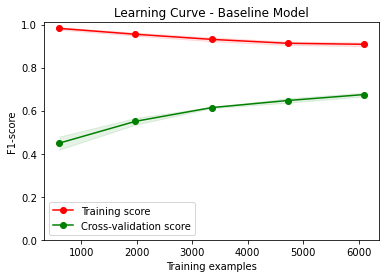

Fold 0:
F1 validation score: 0.6750841750841752

Fold 1:
F1 validation score: 0.6501283147989735

Fold 2:
F1 validation score: 0.6711074104912572

Fold 3:
F1 validation score: 0.6682966585167075

Fold 4:
F1 validation score: 0.6754530477759473

Average F1 validation: 0.6680139213334122


In [84]:
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_dt,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_dt,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

## Lemmatization + Count Vectorization + SVC

In [89]:
steps_svc = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])

#count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
steps_svc.append(('features',col_transformations))
steps_svc.append(('model', svm.LinearSVC(random_state=SEED)))
pipeline_svc = Pipeline(steps=steps_svc)

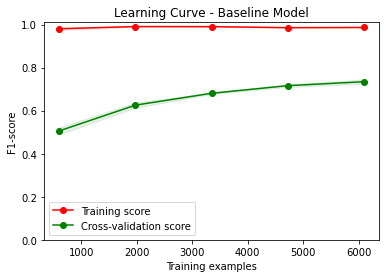

Fold 0:
F1 validation score: 0.7483974358974358

Fold 1:
F1 validation score: 0.7360774818401936

Fold 2:
F1 validation score: 0.7259729944400316

Fold 3:
F1 validation score: 0.721259842519685

Fold 4:
F1 validation score: 0.7394695787831513

Average F1 validation: 0.7342354666960995


In [90]:
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_svc,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_svc,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

The LinearSVC model is overfitting, let's try with the L2 penalty

In [91]:
steps_svc = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])

#count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
steps_svc.append(('features',col_transformations))
steps_svc.append(('model', svm.LinearSVC(penalty = 'l2',
                                         C=0.02,
                                         random_state=SEED)))
pipeline_svc = Pipeline(steps=steps_svc)

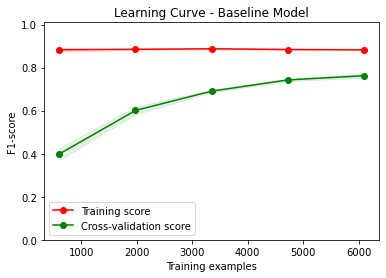

Fold 0:
F1 validation score: 0.7782357790601814

Fold 1:
F1 validation score: 0.7581589958158995

Fold 2:
F1 validation score: 0.749793559042114

Fold 3:
F1 validation score: 0.762301918265221

Fold 4:
F1 validation score: 0.7608695652173912

Average F1 validation: 0.7618719634801614


In [92]:
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_svc,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_svc,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

Great F1-score

## Lemmatization + Count Vectorization + XGBoost

In [107]:
steps_xgb = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])

#count_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None)
steps_xgb.append(('features',col_transformations))
steps_xgb.append(('model', XGBClassifier(eval_metric = 'logloss',
                                         #use_label_encoder= False,
                                         random_state=SEED)))
pipeline_xgb = Pipeline(steps=steps_xgb)

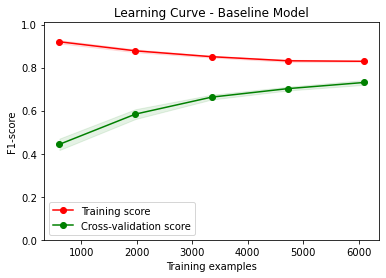

Fold 0:
F1 validation score: 0.74466268146883

Fold 1:
F1 validation score: 0.7255574614065181

Fold 2:
F1 validation score: 0.7186440677966102

Fold 3:
F1 validation score: 0.7314974182444062

Fold 4:
F1 validation score: 0.7218430034129693

Average F1 validation: 0.7284409264658668


In [108]:
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_xgb,
                          cv=CV)

# plot the learning curve
plot_learning_curve(pipeline_xgb,
                    X=train[['keyword','text']],
                    y=train['target'],
                    cv=CV,
                    title="Learning Curve - Baseline Model")

print_score_summary(scores)

## Ensembling LogisticRegression + SVC + XGBoost

In [109]:
estimators = [
    ('logreg', LogisticRegression(solver='saga',
                               C=0.3,
                               fit_intercept=False,
                               max_iter=900,
                               penalty="l2",
                               random_state=SEED)),
    
    ('svc', svm.LinearSVC(penalty="l2",
                          C=0.02,
                          random_state=SEED)),
    
    ('xgbclass', XGBClassifier(eval_metric="logloss",
                              random_state=SEED))
]

steps_ensemble = list()

col_transformations = ColumnTransformer(transformers=[
    ("encoding", OneHotEncoder(handle_unknown='ignore'), ['keyword']),
    ('vectorizarion', CountVectorizer(tokenizer=LemmaTokenizer(), token_pattern=None), 'text')
])
steps_ensemble.append(('features', col_transformations))
steps_ensemble.append(('stacking', StackingClassifier(estimators, cv=CV)))

pipeline_ensemble = Pipeline(steps=steps_ensemble)


In [113]:
scores = get_model_scores(X=train[['keyword','text']],
                          y=train['target'],
                          pipeline=pipeline_ensemble,
                          cv=CV)

print_score_summary(scores)

Fold 0:
F1 validation score: 0.7789646672144617

Fold 1:
F1 validation score: 0.7627677100494236

Fold 2:
F1 validation score: 0.752827140549273

Fold 3:
F1 validation score: 0.7653311529026984

Fold 4:
F1 validation score: 0.7665562913907285

Average F1 validation: 0.765289392421317


We are ready with our final model. Let's predict now and see our F1-score

### Fit on train set & Prediction on test

In [114]:
pipeline_ensemble.fit(train[['keyword','text']],train['target'])

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['keyword']),
                                                 ('vectorizarion',
                                                  CountVectorizer(token_pattern=None,
                                                                  tokenizer=<__main__.LemmaTokenizer object at 0x7fca6c102520>),
                                                  'text')])),
                ('stacking',
                 StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                    estimators=[(...
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance

In [115]:
y_pred = pipeline_ensemble.predict(test[['keyword','text']])